# 0. 기본세팅 & 크롤링 데이터 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install JPype1-1.2.0-cp38-cp38-win_amd64.whl
!pip install konlpy==0.5.2
!pip install tweepy==3.10.0
!pip install keybert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: JPype1-1.2.0-cp38-cp38-win_amd64.whl is not a supported wheel on this platform.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.6/465.6 KB 23.1 MB/s eta 0:00:00
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0

In [4]:
import pandas as pd
import numpy as np
import random
import re, string
from konlpy.tag import Komoran, Hannanum
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from keybert import KeyBERT


In [5]:
data = pd.read_csv('/content/drive/MyDrive/data/test_gs.csv', encoding = 'utf-8-sig')
data_raw = data.copy()
data_raw = data_raw.drop(['Unnamed: 0'], axis=1)
data_raw.head()

,date,title,contents
0,2022-01-03,홈파티 완성하는 ‘잇(eat)템’ 열전 … 멘보샤·피쉬앤칩스 등 세계요리 간편...,GS리테일이 운영하는 편의점 GS25는 세계적 스트리트 패션 브랜드 '베이프(BAP...
1,2022-01-03,"[유통가 이모저모] 신세계 정용진 부회장 ""우리 목표는 '제1의 신세계'""","▲GS리테일 허연수 CEO(부회장)는 3일 오전, GS타워 25층에서 열린 'GS리..."
2,2022-01-03,"GS리테일 신뢰받는 플랫폼기업으로 도약, 허연수 ""유통시장 절대강자""",허연수 GS리테일 대표이사 부회장이 3일 열린 'GS리테일 비전선포식'에서 GS리테...
3,2022-01-03,"GS리테일, New Vision 선포 및 2022년 경영전략 밝표",허연수 GS리테일 CEO가 유튜브로 중계되는 비전 선포식에서 주요 임원들이 참석한 ...
4,2022-01-03,"허연수 GS리테일 대표 ""유통 절대 강자로 도약""",GS리테일이 통합법인의 새로운 비전(New Vision) 선포와 함께 새해 경영 전...


In [6]:
data_raw['text'] = data_raw['title'] + data_raw['contents']

# 1. 전처리

In [7]:
komoran = Komoran()
hannanum = Hannanum()

In [8]:
def preprocess_data(data, data_colname):
    """
      tips: csv 데이터를 받아 지정된 column의 내용을 preprocess 합니다.
      Args:
          data_path : csv데이터의 path
          data_colname : 지정할 column명
      Returns:
          lucy_data : DataFrame
    """
    lucy_data = data

    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\(.*\)|\s-\s.*"," " ,regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\[.*\]|\s-\s.*"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\<.*\>|\s-\s.*"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("무단전재 및 재배포 금지"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("무단 전재 및 재배포 금지"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("©"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("ⓒ"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("저작권자"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace(".* 기자", " ", regex=True) #기자 이름에서 오는 유사도 차단
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("사진 = .*", " ", regex=True) #사진 첨부 문구 삭제
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("사진=.*", " ", regex=True) #사진 첨부 문구 삭제
    lucy_data[data_colname] = lucy_data[data_colname].str.replace('\"', "",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+.[a-zA-Z0-9-.]+)", " ", regex=True) #이메일 주소에서 오는 유사도 차단
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\n"," ")
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\r"," ")
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("\t"," ")
    lucy_data[data_colname] = lucy_data[data_colname].str.replace( "\’" , "", regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("[ ]{2,}"," ",regex=True)
    lucy_data[data_colname] = lucy_data[data_colname].str.replace("?","",regex=True)
    
    return lucy_data

In [9]:
# 불용어 파일 열기
with open('/content/drive/MyDrive/data/stopwords.txt', 'r', encoding='ISO-8859-1') as f:
    list_file = f.readlines() 
stopwords = list_file[0].split(",")

# 정규화, 특수기호 제거
def preprocess(text):
    text=text.str.strip()  
    text=re.compile('<.*?>').sub(' ', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', ' ', str(text).strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text


# 명사/영단어 추출, 한글자 제외, 불용어 제거
def final(text):
    n = []
    for i in range(len(text)):
      word = komoran.nouns(text[i])
      p = komoran.pos(text[i])
      for pos in p:
        if pos[1] in ['SL']:
          word.append(pos[0])
      for w in word:
        if len(w)>1 and w not in stopwords:
          n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess(text):
  return final(text)

In [10]:
data_pre = preprocess_data(data_raw, 'text')

In [11]:
data_pre['text'][587]

'구리지역자활센터 리테일 내일스토어 구리갈매점 출범구리지역자활센터는 리테일과 협약을 맺고 저소득계층의 자활 및 자립을 지원하고자 기업과 연계한 새로운 상생모델인 사회공헌형 자활 슈퍼마켓 내일스토어 구리갈매점 을 구리시 갈매동에 일 '

In [12]:
data_raw['text'][163]

nan

In [12]:
data_pre_2 = data_pre.reset_index(drop=True)

In [13]:
data_pre_2['text'] = data_pre_2['text'].replace(' ', np.nan)
data_pre_2 = data_pre.dropna(axis=0)
data_pre_2 = data_pre.reset_index(drop=True)

In [14]:
data_pre_2['text'] = data_pre_2['text'].replace(' ', np.nan)

In [15]:
data_pre_2 = data_pre_2.dropna(axis=0)

In [16]:
data_pre_2 = data_pre_2.reset_index(drop=True)

In [17]:
data_pre_2

,date,title,contents,text
0,2022-01-03,홈파티 완성하는 ‘잇(eat)템’ 열전 … 멘보샤·피쉬앤칩스 등 세계요리 간편...,GS리테일이 운영하는 편의점 GS25는 세계적 스트리트 패션 브랜드 '베이프(BAP...,홈파티 완성하는 잇 수제맥주 명가 제주맥주 와 협업해 베이프비어 를 선보였다 유럽산...
1,2022-01-03,"[유통가 이모저모] 신세계 정용진 부회장 ""우리 목표는 '제1의 신세계'""","▲GS리테일 허연수 CEO(부회장)는 3일 오전, GS타워 25층에서 열린 'GS리...",신세계 정용진 부회장 우리 목표는 제 의 신세계 리테일 허연수 는 일 오전 타워 ...
2,2022-01-03,"GS리테일 신뢰받는 플랫폼기업으로 도약, 허연수 ""유통시장 절대강자""",허연수 GS리테일 대표이사 부회장이 3일 열린 'GS리테일 비전선포식'에서 GS리테...,리테일 신뢰받는 플랫폼기업으로 도약 허연수 유통시장 절대강자허연수 리테일 대표이사...
3,2022-01-03,"GS리테일, New Vision 선포 및 2022년 경영전략 밝표",허연수 GS리테일 CEO가 유튜브로 중계되는 비전 선포식에서 주요 임원들이 참석한 ...,리테일 선포 및 년 경영전략 밝표허연수 리테일 가 유튜브로 중계되는 비전 선포식에...
4,2022-01-03,"허연수 GS리테일 대표 ""유통 절대 강자로 도약""",GS리테일이 통합법인의 새로운 비전(New Vision) 선포와 함께 새해 경영 전...,허연수 리테일 대표 유통 절대 강자로 도약 리테일이 통합법인의 새로운 비전 는 일 ...
...,...,...,...,...
2679,2023-01-13,LG유플러스 또 고객 정보 유출… 경찰 수사 착수,★GS리테일 판촉비용 전가로 16억 원 과징금 처분 공정거래위원회는 1월 8일 GS...,유플러스 또 고객 정보 유출 경찰 수사 착수 리테일 판촉비용 전가로 억 원 과징금...
2680,2023-01-13,[유통 단신] 신세계L&B·CJ웰케어·할리스 外,"GS25, 생크림 찹쌀떡으로 유명한 익산농협과 맞손 GS25와 익산농협은 1월 12...",신세계 웰케어 할리스 생크림 찹쌀떡으로 유명한 익산농협과 맞손 와 익산농협은 월 ...
2681,2023-01-13,[설선물 트렌드] 이색 상품으로 소비자 눈길 끄는 편의점,GS리테일 제공 편의점 업계가 설 명절을 앞두고 가성비 설선물 세트와 함께 이색적인...,이색 상품으로 소비자 눈길 끄는 편의점 리테일 제공 편의점 업계가 설 명절을 앞두...
2682,2023-01-13,[Who Is ?] 구현모 KT 대표이사 사장,KT는 브라이트 사업을 시작할 때 GS리테일과 손잡고 전국에 가상현실 테마파크 20...,구현모 대표이사 사장 는 브라이트 사업을 시작할 때 리테일과 손잡고 전국에 가상현...


In [18]:
data_pre_2['noun'] = finalpreprocess(data_pre_2['text'])

In [19]:
data_pre_2

,date,title,contents,text,noun
0,2022-01-03,홈파티 완성하는 ‘잇(eat)템’ 열전 … 멘보샤·피쉬앤칩스 등 세계요리 간편...,GS리테일이 운영하는 편의점 GS25는 세계적 스트리트 패션 브랜드 '베이프(BAP...,홈파티 완성하는 잇 수제맥주 명가 제주맥주 와 협업해 베이프비어 를 선보였다 유럽산...,홈파티 완성 수제 맥주 명가 제주 맥주 협업 이프 비어 유럽 품질 고가 시트 사용 ...
1,2022-01-03,"[유통가 이모저모] 신세계 정용진 부회장 ""우리 목표는 '제1의 신세계'""","▲GS리테일 허연수 CEO(부회장)는 3일 오전, GS타워 25층에서 열린 'GS리...",신세계 정용진 부회장 우리 목표는 제 의 신세계 리테일 허연수 는 일 오전 타워 ...,홈파티 완성 수제 맥주 명가 제주 맥주 협업 이프 비어 유럽 품질 고가 시트 사용 ...
2,2022-01-03,"GS리테일 신뢰받는 플랫폼기업으로 도약, 허연수 ""유통시장 절대강자""",허연수 GS리테일 대표이사 부회장이 3일 열린 'GS리테일 비전선포식'에서 GS리테...,리테일 신뢰받는 플랫폼기업으로 도약 허연수 유통시장 절대강자허연수 리테일 대표이사...,홈파티 완성 수제 맥주 명가 제주 맥주 협업 이프 비어 유럽 품질 고가 시트 사용 ...
3,2022-01-03,"GS리테일, New Vision 선포 및 2022년 경영전략 밝표",허연수 GS리테일 CEO가 유튜브로 중계되는 비전 선포식에서 주요 임원들이 참석한 ...,리테일 선포 및 년 경영전략 밝표허연수 리테일 가 유튜브로 중계되는 비전 선포식에...,홈파티 완성 수제 맥주 명가 제주 맥주 협업 이프 비어 유럽 품질 고가 시트 사용 ...
4,2022-01-03,"허연수 GS리테일 대표 ""유통 절대 강자로 도약""",GS리테일이 통합법인의 새로운 비전(New Vision) 선포와 함께 새해 경영 전...,허연수 리테일 대표 유통 절대 강자로 도약 리테일이 통합법인의 새로운 비전 는 일 ...,홈파티 완성 수제 맥주 명가 제주 맥주 협업 이프 비어 유럽 품질 고가 시트 사용 ...
...,...,...,...,...,...
2679,2023-01-13,LG유플러스 또 고객 정보 유출… 경찰 수사 착수,★GS리테일 판촉비용 전가로 16억 원 과징금 처분 공정거래위원회는 1월 8일 GS...,유플러스 또 고객 정보 유출 경찰 수사 착수 리테일 판촉비용 전가로 억 원 과징금...,홈파티 완성 수제 맥주 명가 제주 맥주 협업 이프 비어 유럽 품질 고가 시트 사용 ...
2680,2023-01-13,[유통 단신] 신세계L&B·CJ웰케어·할리스 外,"GS25, 생크림 찹쌀떡으로 유명한 익산농협과 맞손 GS25와 익산농협은 1월 12...",신세계 웰케어 할리스 생크림 찹쌀떡으로 유명한 익산농협과 맞손 와 익산농협은 월 ...,홈파티 완성 수제 맥주 명가 제주 맥주 협업 이프 비어 유럽 품질 고가 시트 사용 ...
2681,2023-01-13,[설선물 트렌드] 이색 상품으로 소비자 눈길 끄는 편의점,GS리테일 제공 편의점 업계가 설 명절을 앞두고 가성비 설선물 세트와 함께 이색적인...,이색 상품으로 소비자 눈길 끄는 편의점 리테일 제공 편의점 업계가 설 명절을 앞두...,홈파티 완성 수제 맥주 명가 제주 맥주 협업 이프 비어 유럽 품질 고가 시트 사용 ...
2682,2023-01-13,[Who Is ?] 구현모 KT 대표이사 사장,KT는 브라이트 사업을 시작할 때 GS리테일과 손잡고 전국에 가상현실 테마파크 20...,구현모 대표이사 사장 는 브라이트 사업을 시작할 때 리테일과 손잡고 전국에 가상현...,홈파티 완성 수제 맥주 명가 제주 맥주 협업 이프 비어 유럽 품질 고가 시트 사용 ...


# 2. 행 추출 : 핵심키워드만 있는 행만

In [20]:
word_corpus = pd.read_csv('/content/drive/MyDrive/data/corpus_esg_keyword_v2.csv', encoding = 'utf-8-sig')
word_corpus = word_corpus['word'].values.tolist()
word_corpus

['폐기물',
 '사용량',
 '온실가스',
 '재활용',
 '원단위',
 '플라스틱',
 '배출량',
 '환경경영',
 '기후변화',
 'LED',
 'PET',
 '탄소중립',
 '사업장',
 '폐가전',
 '업사이클링',
 '음식물',
 '포장재',
 '페트병',
 '물류센터',
 '효율화',
 '코카콜라음료',
 '재활용성',
 '선순환',
 '지속적',
 '정보보호',
 '협력사',
 '안전보건',
 '동반성장',
 '협력회사',
 '개인정보',
 '임직원',
 '근로자',
 '프로그램',
 '정보보안',
 '중소기업',
 '개인정보보호',
 '온라인',
 '화학물질',
 '자율준수',
 '파트너사',
 '컨설팅',
 '경쟁력',
 '육아휴직',
 '유해물질',
 '공정거래',
 '시스템',
 '사업장',
 'ESG',
 '안심품질',
 '품질관리',
 '국내외',
 '프로세스',
 '안전성',
 '공급망',
 '화장품',
 '담당자',
 '안전사고',
 '안전관리',
 '간담회',
 '경영주',
 '플랫폼',
 '위험성',
 '불공정',
 '데이터',
 '매뉴얼',
 '지속적',
 '관리자',
 'HACCP',
 '품질경영',
 '산업재해',
 '전문기관',
 '가맹점',
 '안전보건경영',
 '윤리경영',
 '가이드라인',
 '제조사',
 '이사회',
 '이사회',
 '사내이사',
 '감사위원회',
 'ESG위원회',
 '주주총회',
 '참석률',
 '독립성',
 '위원회',
 '내부거래위원회',
 '지배구조',
 'ESG',
 '보상위원회',
 '대표이사',
 '경영진',
 '위원장',
 '전문성',
 '과반수']

In [21]:
def extract_row(train):  #train은 dataframe

		# join함수를 이용하여 이어주고 contains 함수에 넣기
		user_keywords = '|'.join(word_corpus)
		temp = train[train['noun'].str.contains(user_keywords)]
		train_extract = temp[['date', 'title', 'contents', 'text']]
		train_extract
		return train_extract

# 한나눔 전처리
def final_han(text):
    n = []
    word = hannanum.nouns(text)
    p = hannanum.pos(text)
    for pos in p:
      if pos[1] in ['F']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess_han(text):
  return final_han(text)

In [22]:
data_extract = extract_row(data_pre_2)
data_extract = preprocess_data(data_extract, 'text')
data_extract['text'] = data_extract['text'].replace(' ', np.nan)
data_extract = data_extract.dropna(axis=0)
data_extract = data_extract.reset_index(drop=True)

data_extract['noun'] = data_extract['text'].apply(lambda x: finalpreprocess_han(x))
data_extract

,date,title,contents,text,noun
0,2022-01-03,홈파티 완성하는 ‘잇(eat)템’ 열전 … 멘보샤·피쉬앤칩스 등 세계요리 간편...,GS리테일이 운영하는 편의점 GS25는 세계적 스트리트 패션 브랜드 '베이프(BAP...,홈파티 완성하는 잇 수제맥주 명가 제주맥주 와 협업해 베이프비어 를 선보였다 유럽산...,홈파티 완성 수제맥주 제주맥주 협업 베이프비 유럽산 고품질 맥아 고가 시트 사용 맥...
1,2022-01-03,"[유통가 이모저모] 신세계 정용진 부회장 ""우리 목표는 '제1의 신세계'""","▲GS리테일 허연수 CEO(부회장)는 3일 오전, GS타워 25층에서 열린 'GS리...",신세계 정용진 부회장 우리 목표는 제 의 신세계 리테일 허연수 는 일 오전 타워 ...,신세계 정용진 부회장 우리 목표 신세계 리테 허연수 오전 타워 리테일 비전 선포식 ...
2,2022-01-03,"GS리테일 신뢰받는 플랫폼기업으로 도약, 허연수 ""유통시장 절대강자""",허연수 GS리테일 대표이사 부회장이 3일 열린 'GS리테일 비전선포식'에서 GS리테...,리테일 신뢰받는 플랫폼기업으로 도약 허연수 유통시장 절대강자허연수 리테일 대표이사...,리테 신뢰 플랫폼기업 도약 허연수 유통시장 절대강자허연수 리테 대표이사 부회장 리테...
3,2022-01-03,"GS리테일, New Vision 선포 및 2022년 경영전략 밝표",허연수 GS리테일 CEO가 유튜브로 중계되는 비전 선포식에서 주요 임원들이 참석한 ...,리테일 선포 및 년 경영전략 밝표허연수 리테일 가 유튜브로 중계되는 비전 선포식에...,리테 선포 경영전략 밝표허연수 리테일 유튜브 중계 비전 선포식 주요 임원들 참석 가...
4,2022-01-03,"허연수 GS리테일 대표 ""유통 절대 강자로 도약""",GS리테일이 통합법인의 새로운 비전(New Vision) 선포와 함께 새해 경영 전...,허연수 리테일 대표 유통 절대 강자로 도약 리테일이 통합법인의 새로운 비전 는 일 ...,허연수 리테 대표 유통 절대 강자 도약 리테일 통합법인 비전 서울 역삼동 타워 리테...
...,...,...,...,...,...
2679,2023-01-13,LG유플러스 또 고객 정보 유출… 경찰 수사 착수,★GS리테일 판촉비용 전가로 16억 원 과징금 처분 공정거래위원회는 1월 8일 GS...,유플러스 또 고객 정보 유출 경찰 수사 착수 리테일 판촉비용 전가로 억 원 과징금...,유플러스 고객 정보 유출 경찰 수사 착수 리테 판촉비용 전가 과징금 처분 공정거래위...
2680,2023-01-13,[유통 단신] 신세계L&B·CJ웰케어·할리스 外,"GS25, 생크림 찹쌀떡으로 유명한 익산농협과 맞손 GS25와 익산농협은 1월 12...",신세계 웰케어 할리스 생크림 찹쌀떡으로 유명한 익산농협과 맞손 와 익산농협은 월 ...,신세계 웰케 할리스 생크림 찹쌀떡 유명 익산농협 맞손 익산농협 전라북 익산시 인화동...
2681,2023-01-13,[설선물 트렌드] 이색 상품으로 소비자 눈길 끄는 편의점,GS리테일 제공 편의점 업계가 설 명절을 앞두고 가성비 설선물 세트와 함께 이색적인...,이색 상품으로 소비자 눈길 끄는 편의점 리테일 제공 편의점 업계가 설 명절을 앞두...,이색 상품 소비자 눈길 편의점 리테 제공 편의점 업계 명절 가성비 설선물 세트 이색...
2682,2023-01-13,[Who Is ?] 구현모 KT 대표이사 사장,KT는 브라이트 사업을 시작할 때 GS리테일과 손잡고 전국에 가상현실 테마파크 20...,구현모 대표이사 사장 는 브라이트 사업을 시작할 때 리테일과 손잡고 전국에 가상현...,구현모 대표이사 사장 브라이트 사업 시작 리테일 전국 가상현실 테마파크 지점 계획 ...


# 2. 클러스터링 #1 (중복기사제거)

In [23]:
text = data_extract['noun']

In [24]:
#1 tf-idf 임베딩(+Normalize)
def tfidf_vectorizer(text, min_df=3, ngram_range=(1,5)):
    tfidf_vectorizer = TfidfVectorizer(min_df = 3, ngram_range=(1,5)) #min_df :최소 빈도값 (단어 등장하는 문서 수)
    tfidf_vectorizer.fit(text)
    vector = tfidf_vectorizer.transform(text).toarray()
    vector = np.array(vector) # Normalizer를 이용해 이미 변환된 벡터
    return vector

vector_1st = tfidf_vectorizer(text, min_df=1)

In [25]:
#2 DBSCAN Clustering

model = DBSCAN(eps=0.1,min_samples=1, metric = "cosine") 
#     거리 계산 식으로는 Cosine distance를 이용
#     eps이 낮을수록, min_samples 값이 높을수록 군집으로 판단하는 기준이 까다로움.
result_1st = model.fit_predict(vector_1st)
data_extract['cluster1st'] = result_1st

print('군집개수 :', result_1st.max())
data_extract

군집개수 : 2501


,date,title,contents,text,noun,cluster1st
0,2022-01-03,홈파티 완성하는 ‘잇(eat)템’ 열전 … 멘보샤·피쉬앤칩스 등 세계요리 간편...,GS리테일이 운영하는 편의점 GS25는 세계적 스트리트 패션 브랜드 '베이프(BAP...,홈파티 완성하는 잇 수제맥주 명가 제주맥주 와 협업해 베이프비어 를 선보였다 유럽산...,홈파티 완성 수제맥주 제주맥주 협업 베이프비 유럽산 고품질 맥아 고가 시트 사용 맥...,0
1,2022-01-03,"[유통가 이모저모] 신세계 정용진 부회장 ""우리 목표는 '제1의 신세계'""","▲GS리테일 허연수 CEO(부회장)는 3일 오전, GS타워 25층에서 열린 'GS리...",신세계 정용진 부회장 우리 목표는 제 의 신세계 리테일 허연수 는 일 오전 타워 ...,신세계 정용진 부회장 우리 목표 신세계 리테 허연수 오전 타워 리테일 비전 선포식 ...,1
2,2022-01-03,"GS리테일 신뢰받는 플랫폼기업으로 도약, 허연수 ""유통시장 절대강자""",허연수 GS리테일 대표이사 부회장이 3일 열린 'GS리테일 비전선포식'에서 GS리테...,리테일 신뢰받는 플랫폼기업으로 도약 허연수 유통시장 절대강자허연수 리테일 대표이사...,리테 신뢰 플랫폼기업 도약 허연수 유통시장 절대강자허연수 리테 대표이사 부회장 리테...,2
3,2022-01-03,"GS리테일, New Vision 선포 및 2022년 경영전략 밝표",허연수 GS리테일 CEO가 유튜브로 중계되는 비전 선포식에서 주요 임원들이 참석한 ...,리테일 선포 및 년 경영전략 밝표허연수 리테일 가 유튜브로 중계되는 비전 선포식에...,리테 선포 경영전략 밝표허연수 리테일 유튜브 중계 비전 선포식 주요 임원들 참석 가...,3
4,2022-01-03,"허연수 GS리테일 대표 ""유통 절대 강자로 도약""",GS리테일이 통합법인의 새로운 비전(New Vision) 선포와 함께 새해 경영 전...,허연수 리테일 대표 유통 절대 강자로 도약 리테일이 통합법인의 새로운 비전 는 일 ...,허연수 리테 대표 유통 절대 강자 도약 리테일 통합법인 비전 서울 역삼동 타워 리테...,4
...,...,...,...,...,...,...
2679,2023-01-13,LG유플러스 또 고객 정보 유출… 경찰 수사 착수,★GS리테일 판촉비용 전가로 16억 원 과징금 처분 공정거래위원회는 1월 8일 GS...,유플러스 또 고객 정보 유출 경찰 수사 착수 리테일 판촉비용 전가로 억 원 과징금...,유플러스 고객 정보 유출 경찰 수사 착수 리테 판촉비용 전가 과징금 처분 공정거래위...,2498
2680,2023-01-13,[유통 단신] 신세계L&B·CJ웰케어·할리스 外,"GS25, 생크림 찹쌀떡으로 유명한 익산농협과 맞손 GS25와 익산농협은 1월 12...",신세계 웰케어 할리스 생크림 찹쌀떡으로 유명한 익산농협과 맞손 와 익산농협은 월 ...,신세계 웰케 할리스 생크림 찹쌀떡 유명 익산농협 맞손 익산농협 전라북 익산시 인화동...,2489
2681,2023-01-13,[설선물 트렌드] 이색 상품으로 소비자 눈길 끄는 편의점,GS리테일 제공 편의점 업계가 설 명절을 앞두고 가성비 설선물 세트와 함께 이색적인...,이색 상품으로 소비자 눈길 끄는 편의점 리테일 제공 편의점 업계가 설 명절을 앞두...,이색 상품 소비자 눈길 편의점 리테 제공 편의점 업계 명절 가성비 설선물 세트 이색...,2499
2682,2023-01-13,[Who Is ?] 구현모 KT 대표이사 사장,KT는 브라이트 사업을 시작할 때 GS리테일과 손잡고 전국에 가상현실 테마파크 20...,구현모 대표이사 사장 는 브라이트 사업을 시작할 때 리테일과 손잡고 전국에 가상현...,구현모 대표이사 사장 브라이트 사업 시작 리테일 전국 가상현실 테마파크 지점 계획 ...,2500


In [28]:
def print_cluster_result(train, result, col_cluster):
    # train : 데이터, result : 군집화 결과, col_cluster : 클러스터넘버 컬럼명
    clusters = []
    date = []
    counts = []
    titles = []
    urls = []
    thumbnails = []
    nouns = []
    for cluster_num in set(result):
            print("cluster num : {}".format(cluster_num))
            temp_df = train[train[col_cluster] == cluster_num] # cluster num 별로 조회
            clusters.append(cluster_num)
            counts.append(len(temp_df))
            date.append(temp_df.reset_index()['date'][0])
            titles.append(temp_df.reset_index()['title'][0])
            urls.append(temp_df.reset_index()['contents'][0])
            thumbnails.append(temp_df.reset_index()['text'][0])
            nouns.append(temp_df.reset_index()['noun'][0]) 

            for title in temp_df['title']:
                print(title) # 제목으로 살펴보자
            print()

    cluster_result = pd.DataFrame({'date':date, 'cluster_num':clusters, 'count':counts, 'title': titles, 'contents':urls, 'text':thumbnails, 'noun': nouns})
    return cluster_result


In [29]:
cluster1_result = print_cluster_result( train=data_extract, 
                                       result=result_1st, col_cluster="cluster1st")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

cluster num : 876
尹 대통령, 물가 안정 주문에…"고통 분담해야하나" 유통업계 전전긍긍

cluster num : 877
구자학 아워홈 회장 별세···드봉·페리오·PBT·램버스D램···'LG家의 세...

cluster num : 878
‘NO재팬’ 끝났나... 사라지는 불매운동, 살아나는 일본기업

cluster num : 879
손경식·허창수, 구자학 아워홈 회장 빈소 찾아 애도

cluster num : 880
아워홈 구자학 회장 별세, '남매의 난' 결말은

cluster num : 881
‘원소주’ 품은 GS25, 주류판도 바꾼다 [인터뷰]

cluster num : 882
GS리테일, ‘위주’와 맞손…“퀵커머스로 전통시장 활성화”

cluster num : 883
GS리테일, 위주와 MOU…전통시장 활성화 사업 추진

cluster num : 884
GS리테일, 친환경 퀵커머스 상생 모델 구축

cluster num : 885
GS리테일, '위주'와 맞손…“전통시장 활성화에 도보배달 플랫폼 활용”

cluster num : 886
1분기 실적 주춤한 홈쇼핑...신사업으로 극복 기대

cluster num : 887
GS리테일, "도보 배달원이 전통시장 상품 배송해준다"

cluster num : 888
GS리테일, ‘위주’와 MOU…“퀵커머스로 전통시장 활성화”

cluster num : 889
편의점 '술 전쟁' 여름 성수기 달군다

cluster num : 890
GS리테일, 위주와 업무협약…전통시장 활성화 '상생모델 구축

cluster num : 891
GS리테일, 친환경 퀵커머스 상생 모델 구축

cluster num : 892
GS리테일·요기요 협업…생필품 1시간 내 배송 ‘요마트’ 서비스[포토뉴스]

cluster num : 893
GS리테일의 야심작, '요마트' 론칭…실적 반등할까

cluster num : 894
홈리빙 1위 모던하우스, 5년만에 매각 절

In [30]:
cluster1_result.head()

,date,cluster_num,count,title,contents,text,noun
0,2022-01-03,0,1,홈파티 완성하는 ‘잇(eat)템’ 열전 … 멘보샤·피쉬앤칩스 등 세계요리 간편...,GS리테일이 운영하는 편의점 GS25는 세계적 스트리트 패션 브랜드 '베이프(BAP...,홈파티 완성하는 잇 수제맥주 명가 제주맥주 와 협업해 베이프비어 를 선보였다 유럽산...,홈파티 완성 수제맥주 제주맥주 협업 베이프비 유럽산 고품질 맥아 고가 시트 사용 맥...
1,2022-01-03,1,1,"[유통가 이모저모] 신세계 정용진 부회장 ""우리 목표는 '제1의 신세계'""","▲GS리테일 허연수 CEO(부회장)는 3일 오전, GS타워 25층에서 열린 'GS리...",신세계 정용진 부회장 우리 목표는 제 의 신세계 리테일 허연수 는 일 오전 타워 ...,신세계 정용진 부회장 우리 목표 신세계 리테 허연수 오전 타워 리테일 비전 선포식 ...
2,2022-01-03,2,1,"GS리테일 신뢰받는 플랫폼기업으로 도약, 허연수 ""유통시장 절대강자""",허연수 GS리테일 대표이사 부회장이 3일 열린 'GS리테일 비전선포식'에서 GS리테...,리테일 신뢰받는 플랫폼기업으로 도약 허연수 유통시장 절대강자허연수 리테일 대표이사...,리테 신뢰 플랫폼기업 도약 허연수 유통시장 절대강자허연수 리테 대표이사 부회장 리테...
3,2022-01-03,3,1,"GS리테일, New Vision 선포 및 2022년 경영전략 밝표",허연수 GS리테일 CEO가 유튜브로 중계되는 비전 선포식에서 주요 임원들이 참석한 ...,리테일 선포 및 년 경영전략 밝표허연수 리테일 가 유튜브로 중계되는 비전 선포식에...,리테 선포 경영전략 밝표허연수 리테일 유튜브 중계 비전 선포식 주요 임원들 참석 가...
4,2022-01-03,4,1,"허연수 GS리테일 대표 ""유통 절대 강자로 도약""",GS리테일이 통합법인의 새로운 비전(New Vision) 선포와 함께 새해 경영 전...,허연수 리테일 대표 유통 절대 강자로 도약 리테일이 통합법인의 새로운 비전 는 일 ...,허연수 리테 대표 유통 절대 강자 도약 리테일 통합법인 비전 서울 역삼동 타워 리테...


# 3. 클러스터링 #2

In [31]:
text2 = cluster1_result['noun']
vector_2nd = tfidf_vectorizer(text2, min_df=1)

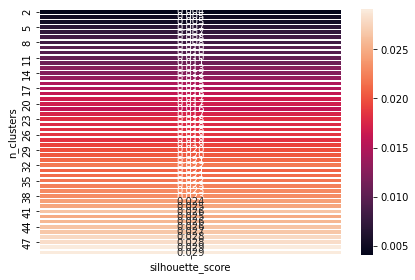

In [44]:
# Silhouette Score - 최적 k
def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(2,50)
    results = []

    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init=param_init, n_init=param_n_init, max_iter=param_max_iter, random_state=0)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

visualize_silhouette_layer(vector_2nd) # 가장 높은 실루엣 계수와 매핑되는 k

In [33]:
# kmeans 군집 결과 확인
from sklearn.cluster import KMeans

result_2nd = KMeans(n_clusters=49).fit_predict(vector_2nd)
cluster1_result['cluster2nd'] = result_2nd

cluster2_result = print_cluster_result( train=cluster1_result, 
                                       result=result_2nd, col_cluster="cluster2nd")

cluster num : 0
1월 7일 궂긴소식
환경 잡은 GS, 허태수 회장의 ESG 경영 '속도전'
[구자홍 별세] 사흘째 빈소 찾은 구광모 LG 회장…정재계 추모 행렬(종합)
'LS의 큰별' 故 구자홍 회장…한마음으로 추모한 범LG일가
허창수 GS 명예회장 “오래 살 줄 알았는데…”
인천시-인천상공회-GS리테일, 어르신 일자리 창출 협약
인천시, 경제단체·기업과 손잡고 어르신 일자리 마련에 힘쓴다
트러스톤, 태광산업에 경고장…"과거로 회귀 안돼"
GS, 그룹 차원 'ESG헌장' 제정…계열사 가이드라인 제시
그룹 차원 'ESG헌장' 제정한 GS...ESG경영도 차별화
GS리테일, 핫플 카페 브랜드 '카멜커피'와 컬래버 업무협약 체결
'재벌 창업주 배출' 지수초교 총동창회, 조규일 진주시장에 감사패
인천시, GS25시니어드림스토어 2호점 개점
'GS인천남동점' 개점 어르신 인생 2막 활짝
노인 일자리창출 최선 다하는 인천시… 남동구에 'GS25 시니어드림스토어' 2호...
남동구에 은퇴노인을 위한 GS25시니어드림스토어 2호점 개점
인천 남동구에 'GS25시니어드림스토어' 2호점 개점
배터리 업계에 부는 '전구체 바람'...포스코케미칼·LG화학 이어 코스모그룹 ...
범LG 23년간 잡음없이 줄줄이 계열분리
[구자학 별세] 구지은 아워홈 부회장 "나는 오늘도 아버지께 배운다"
故구자학 아워홈 회장의 음식 사랑
홍라희 이부진 이재현 구광모, 아워홈 회장 구자학 빈소 찾아 조문
구자학 아워홈 회장 별세...사업보국 일념으로 경영활동 이어와
식품·화학·전자·건설 불모지 개척… '사업보국' 산업화 1세대 경영인
'한국 산업화 1세대' 아워홈 구자학 회장 별세…향년 92세
아워홈 일군 '산업화 1세대' 구자학 회장 별세... 매듭 못 푼 '남매의 난' 향...
구자학 아워홈 회장 별세···드봉·페리오·PBT·램버스D램···'LG家의 세...
손경식·허창수, 구자학 아워홈 회장 빈소 찾아 애도
아워홈 구자학 회장 별세, '남매의 난' 결말은
구자학 아워홈 회장 별세, 

In [ ]:
# cluster2_result.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/final_cluster2_result.csv', index=False)
# cluster1_result.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/final_cluster1_result.csv', index=False)

# 4. keyword 추출

In [34]:
key_model = KeyBERT('paraphrase-multilingual-MiniLM-L12-v2')  #distilbert-base-nli-mean-tokens / paraphrase-multilingual-MiniLM-L12-v2

In [43]:
def keyword(data, col_cluster):  #data = cluster_result (데이터프레임) #1분 30초 소요됨
    result = []
    for i in range(len(data)):
        key_text = cluster1_result[cluster1_result[col_cluster]==i]['noun']
        key_text = ' '.join(key_text)
        keyword = key_model.extract_keywords(key_text, keyphrase_ngram_range=(1,2), top_n=5)
        for i in range(5):
          result.append(keyword[i][0])
    print(result)
    return result

def merge_keyword(data, col_cluster): #새 열로 추가.
    data_temp = data.copy()
    data_temp['keyword'] = keyword(data, col_cluster)
    return data_temp

keyword_result = merge_keyword(cluster2_result, col_cluster='cluster2nd')

keyword_df = keyword_result[['cluster_num', 'count', 'keyword']]
keyword_df.sort_values(by='count', ascending=False, inplace=True, ignore_index=True)
keyword_df.drop(index=[0], inplace=True)
keyword_df = keyword_df[keyword_df['count']>5]
lst = []
for i in keyword_df['keyword']:
  lst.append(i.upper())
keyword_df['keyword'] = lst
keyword_df


[('인천상공회의소 회장', 0.6331), ('상반기 인천도시공사', 0.6313), ('명예회장 락희화학공업', 0.6227), ('인천시 경제단체', 0.6205), ('인천시 인천상공회의소', 0.6199)]
[('이마트 롯데쇼핑', 0.7238), ('롯데하이마트 현대홈쇼핑', 0.7064), ('저점매수 유효이마트', 0.7048), ('대장들월마트 실적발표', 0.6952), ('대장들월마트', 0.6914)]
[('업무협약 체결비하이인베트스먼트', 0.7642), ('업무협약 체결여주시', 0.7055), ('체결 서포터즈', 0.6986), ('네오엔터디엑스 체결', 0.6911), ('체결비하이인베트스먼트', 0.6896)]
[('코리아크래프트브루어리 롯데마트', 0.6664), ('행사가격 기존', 0.656), ('어바웃펫 롯데마트', 0.6411), ('이마트 몰리스펫샵', 0.6362), ('행사가격 만원', 0.6322)]
[('기업형슈퍼마켓 더프레시', 0.7829), ('리테일 기업형슈퍼마켓', 0.7491), ('배달앱 회사들', 0.7392), ('마트 배민스토', 0.7165), ('나선다배민 마트', 0.7157)]
[('경영보고서 내놨다', 0.7459), ('리테일 정기주주총회', 0.7425), ('경영보고 지난해', 0.7393), ('전략본부 산하', 0.7327), ('지속가능경영보고 리테일', 0.7298)]
[('편의점 진또배기맵싹갈비삼각김밥', 0.7726), ('로보아르테 편의점', 0.7571), ('편의점 할랄인증', 0.7521), ('슈퍼마켓 롯데슈퍼', 0.7507), ('편의점 라이스커머스', 0.7455)]
[('할인행사 이마트', 0.7953), ('할인전이번 행사', 0.7737), ('특별 할인전이번', 0.7598), ('최대 할인행사', 0.7578), ('할인이번 행사', 0.7565)]
[('인기이마트 가성비', 0.7556), ('상품 인기이마트', 0.7456), ('상품 프레

ValueError: ignored

In [36]:
keyword_df.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/keyword_result.csv', index=False)


FileNotFoundError: ignored

# 5. 최종 데이터

In [39]:
cluster1_result[['date', 'title', 'contents', 'text', 'cluster2nd']]

,date,title,contents,text,cluster2nd
0,2022-01-03,홈파티 완성하는 ‘잇(eat)템’ 열전 … 멘보샤·피쉬앤칩스 등 세계요리 간편...,GS리테일이 운영하는 편의점 GS25는 세계적 스트리트 패션 브랜드 '베이프(BAP...,홈파티 완성하는 잇 수제맥주 명가 제주맥주 와 협업해 베이프비어 를 선보였다 유럽산...,25
1,2022-01-03,"[유통가 이모저모] 신세계 정용진 부회장 ""우리 목표는 '제1의 신세계'""","▲GS리테일 허연수 CEO(부회장)는 3일 오전, GS타워 25층에서 열린 'GS리...",신세계 정용진 부회장 우리 목표는 제 의 신세계 리테일 허연수 는 일 오전 타워 ...,29
2,2022-01-03,"GS리테일 신뢰받는 플랫폼기업으로 도약, 허연수 ""유통시장 절대강자""",허연수 GS리테일 대표이사 부회장이 3일 열린 'GS리테일 비전선포식'에서 GS리테...,리테일 신뢰받는 플랫폼기업으로 도약 허연수 유통시장 절대강자허연수 리테일 대표이사...,29
3,2022-01-03,"GS리테일, New Vision 선포 및 2022년 경영전략 밝표",허연수 GS리테일 CEO가 유튜브로 중계되는 비전 선포식에서 주요 임원들이 참석한 ...,리테일 선포 및 년 경영전략 밝표허연수 리테일 가 유튜브로 중계되는 비전 선포식에...,25
4,2022-01-03,"허연수 GS리테일 대표 ""유통 절대 강자로 도약""",GS리테일이 통합법인의 새로운 비전(New Vision) 선포와 함께 새해 경영 전...,허연수 리테일 대표 유통 절대 강자로 도약 리테일이 통합법인의 새로운 비전 는 일 ...,29
...,...,...,...,...,...
2497,2023-01-13,대기업들 설 상생...협력사 납품대금 앞당겨 지급,또한 GS리테일은 가맹점 경영주와 협력사에 정산금과 물품 대금 1800억원을 조기 ...,대기업들 설 상생 협력사 납품대금 앞당겨 지급또한 리테일은 가맹점 경영주와 협력사에...,1
2498,2023-01-13,LG유플러스 또 고객 정보 유출… 경찰 수사 착수,★GS리테일 판촉비용 전가로 16억 원 과징금 처분 공정거래위원회는 1월 8일 GS...,유플러스 또 고객 정보 유출 경찰 수사 착수 리테일 판촉비용 전가로 억 원 과징금...,25
2499,2023-01-13,[설선물 트렌드] 이색 상품으로 소비자 눈길 끄는 편의점,GS리테일 제공 편의점 업계가 설 명절을 앞두고 가성비 설선물 세트와 함께 이색적인...,이색 상품으로 소비자 눈길 끄는 편의점 리테일 제공 편의점 업계가 설 명절을 앞두...,8
2500,2023-01-13,[Who Is ?] 구현모 KT 대표이사 사장,KT는 브라이트 사업을 시작할 때 GS리테일과 손잡고 전국에 가상현실 테마파크 20...,구현모 대표이사 사장 는 브라이트 사업을 시작할 때 리테일과 손잡고 전국에 가상현...,25


In [1]:
final

NameError: ignored

In [40]:
temp_df = cluster1_result[['date', 'title', 'contents', 'text', 'cluster2nd']]
final = keyword_df.merge(temp_df, left_on='cluster_num', right_on='cluster2nd').drop(columns=['count'])
final_temp = final.iloc[:, :3] 
final_temp

,cluster_num,keyword,date
0,8,인기이마트 가성비,2022-01-05
1,8,인기이마트 가성비,2022-01-06
2,8,인기이마트 가성비,2022-01-07
3,8,인기이마트 가성비,2022-01-10
4,8,인기이마트 가성비,2022-01-12
...,...,...,...
2033,30,상업자표시신용카드,2022-06-20
2034,30,상업자표시신용카드,2022-10-04
2035,30,상업자표시신용카드,2022-10-04
2036,30,상업자표시신용카드,2022-10-04


In [38]:
final_temp[1200:1250]

,cluster_num,keyword,date
1200,35,이마트몰 새벽배송몰,2023-01-12
1201,5,경영보고서 내놨다,2022-01-03
1202,5,경영보고서 내놨다,2022-01-04
1203,5,경영보고서 내놨다,2022-01-04
1204,5,경영보고서 내놨다,2022-01-12
1205,5,경영보고서 내놨다,2022-01-14
1206,5,경영보고서 내놨다,2022-01-17
1207,5,경영보고서 내놨다,2022-01-20
1208,5,경영보고서 내놨다,2022-01-24
1209,5,경영보고서 내놨다,2022-02-21


In [ ]:
temp_df.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/reports.csv', index=False)
final.to_csv('/content/drive/MyDrive/와이빅타/DA_주니어플젝/final.csv', index=False)